In [1]:
%matplotlib inline


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import pearsonr

from loren_frank_data_processing import (make_epochs_dataframe,make_neuron_dataframe)
from src.parameters import (ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS)
from src.load_data import get_sleep_and_prev_run_epochs
from ZilongCode.utils import get_sweep_and_sleep_replay_results_using_postive_negative_peak_in_LFP

In [3]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
(neuron_info.type == 'principal') &
(neuron_info.numspikes > 100) &
neuron_info.area.isin(_BRAIN_AREAS)]

n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)

# select only sleep epochs
is_sleep = (epoch_info.type.isin(['sleep']))

is_animal = epoch_info.index.isin(['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha'], level='animal')

#get valid epochs with is_sleep and is_animal and n_neurons > MIN_N_NEURONS
valid_epochs =  epoch_info.loc[is_sleep & 
                                is_animal & 
                                (epoch_info.n_neurons > MIN_N_NEURONS)]

sleep_epoch_keys, prev_run_epoch_keys = get_sleep_and_prev_run_epochs()

# get valid sleep epochs with keys only in sleep_epoch_keys
valid_sleep_epochs = valid_epochs.loc[valid_epochs.index.isin(sleep_epoch_keys)]

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

animal_names = ['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']


In [28]:

all_sweep_len_peranimal = {}; all_sweep_len_perday = {}
all_exponent_peranimal = {}; all_exponent_perday = {}
all_intercept_peranimal = {}; all_intercept_perday = {}
all_ave_speed_peranimal = {}; all_ave_speed_perday = {}

for name in animal_names:
    
    is_animal = epoch_info.index.isin([name], level='animal')

    valid_epochs =  epoch_info.loc[is_sleep & 
                                   is_animal & 
                                   (epoch_info.n_neurons > MIN_N_NEURONS)]

    valid_sleep_epochs = valid_epochs.loc[valid_epochs.index.isin(sleep_epoch_keys)]
    
    sweep_len = []
    exponent = []
    intercept = []
    ave_speed = []
    for sleep_epoch_key in tqdm(valid_sleep_epochs.index, desc='epochs'):
        
        #get previous run epoch key
        prev_run_epoch_key = prev_run_epoch_keys[sleep_epoch_keys.index(sleep_epoch_key)]
        animal_run, day_run, epoch_run = prev_run_epoch_key
        animal_sleep, day_sleep, epoch_sleep = sleep_epoch_key
        
        #skip 'egy', 10, 2 since no mental_distance_from_actual_position is saved (double check later)
        if (animal_run, day_run, epoch_run ) == ('egy', 10, 2):
            continue

        if (animal_run, day_run, epoch_run ) == ('dud', 6, 4):
            continue
        
        sleep_result = os.path.join(
            DATA_DIR,
            "TrueSleepReplayTrajectories",
            (f"{animal_sleep}_{day_sleep:02d}_{epoch_sleep:02d}_traj.pkl"),
            )  
        #if sleep_result does not exist, skip
        if not os.path.exists(sleep_result):
            continue

        print(f'Animal: {animal_run}, Day: {day_run}, Epoch: {epoch_run}')
        
        #get the average sweep length and replay exponent
        results = get_sweep_and_sleep_replay_results_using_postive_negative_peak_in_LFP(prev_run_epoch_key, sleep_epoch_key, DATA_DIR, sweep_speed_threshold=4)
        
        [mean_immobile_speed, 
         mean_active_speed, 
         behav_exp, 
         mean_sweep_dist, 
         mean_sweep_amp, 
         mean_sweep_ahead, 
         mean_sweep_behind, 
         sweep_mass_i,
         replay_exponent, 
         replay_intercept] = results
        
        #print the average sweep length and replay exponent in one line, keep three decimal places
        print(f'Average sweep length: {mean_sweep_amp:.3f}, Diffusion exponent: {replay_exponent:.3f}')
        
        #attach (without overwriting) mean_immobile_speed, mean_sweep_dist, replay_exponent to 
        #all_sweep_len_perday, all_exponent_perday, all_ave_speed_perday with the key of (animal, day)
        all_sweep_len_perday.setdefault((animal_run, day_run), []).append(mean_sweep_amp)
        all_exponent_perday.setdefault((animal_run, day_run), []).append(replay_exponent)
        all_intercept_perday.setdefault((animal_run, day_run), []).append(replay_intercept)
        all_ave_speed_perday.setdefault((animal_run, day_run), []).append(mean_immobile_speed)
        
        ave_speed.append(mean_immobile_speed)
        sweep_len.append(mean_sweep_amp)
        exponent.append(replay_exponent)
        intercept.append(replay_intercept)
    
    all_ave_speed_peranimal[name] = ave_speed  
    all_sweep_len_peranimal[name] = sweep_len
    all_exponent_peranimal[name] = exponent
    all_intercept_peranimal[name] = intercept

epochs:   0%|          | 0/23 [00:00<?, ?it/s]

Animal: bon, Day: 3, Epoch: 2
Average sweep length: 49.932, Diffusion exponent: 0.651
Animal: bon, Day: 3, Epoch: 4
Average sweep length: 34.348, Diffusion exponent: 0.517
Animal: bon, Day: 3, Epoch: 6
Average sweep length: 43.452, Diffusion exponent: 0.525
Animal: bon, Day: 4, Epoch: 4
Average sweep length: 35.363, Diffusion exponent: 0.955
Animal: bon, Day: 4, Epoch: 6
Average sweep length: 44.658, Diffusion exponent: 0.690
Animal: bon, Day: 5, Epoch: 2
Average sweep length: 33.390, Diffusion exponent: 0.572
Animal: bon, Day: 5, Epoch: 4
Average sweep length: 31.837, Diffusion exponent: 0.556
Animal: bon, Day: 6, Epoch: 2
Average sweep length: 36.235, Diffusion exponent: 0.542
Animal: bon, Day: 6, Epoch: 4
Average sweep length: 32.402, Diffusion exponent: 0.548
Animal: bon, Day: 6, Epoch: 6
Average sweep length: 42.844, Diffusion exponent: 0.584
Animal: bon, Day: 7, Epoch: 2
Average sweep length: 34.842, Diffusion exponent: 0.530
Animal: bon, Day: 7, Epoch: 4
Average sweep length: 31

epochs:   0%|          | 0/27 [00:00<?, ?it/s]

Animal: fra, Day: 6, Epoch: 6
Average sweep length: 33.698, Diffusion exponent: 0.629


epochs:   0%|          | 0/17 [00:00<?, ?it/s]

Animal: gov, Day: 7, Epoch: 4
Average sweep length: 45.809, Diffusion exponent: 0.855
Animal: gov, Day: 8, Epoch: 4
Average sweep length: 47.207, Diffusion exponent: 0.771
Animal: gov, Day: 8, Epoch: 6
Average sweep length: 52.232, Diffusion exponent: 0.703
Animal: gov, Day: 9, Epoch: 5
Average sweep length: 51.276, Diffusion exponent: 0.683
Animal: gov, Day: 11, Epoch: 4
Average sweep length: 56.690, Diffusion exponent: 0.852
Animal: gov, Day: 12, Epoch: 6
Average sweep length: 47.958, Diffusion exponent: 0.792
Animal: gov, Day: 13, Epoch: 6
Average sweep length: 52.889, Diffusion exponent: 0.817


epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Animal: dud, Day: 2, Epoch: 2
Average sweep length: 59.189, Diffusion exponent: 0.718


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Animal: con, Day: 1, Epoch: 4
Average sweep length: 46.733, Diffusion exponent: 0.804
Animal: con, Day: 2, Epoch: 2
Average sweep length: 46.062, Diffusion exponent: 0.618
Animal: con, Day: 2, Epoch: 4
Average sweep length: 47.894, Diffusion exponent: 0.627
Animal: con, Day: 3, Epoch: 2
Average sweep length: 44.551, Diffusion exponent: 0.929
Animal: con, Day: 3, Epoch: 4
Average sweep length: 43.777, Diffusion exponent: 0.754
Animal: con, Day: 4, Epoch: 6
Average sweep length: 41.295, Diffusion exponent: 0.761
Animal: con, Day: 5, Epoch: 2
Average sweep length: 41.453, Diffusion exponent: 0.612
Animal: con, Day: 6, Epoch: 2
Average sweep length: 48.002, Diffusion exponent: 0.621
Animal: con, Day: 6, Epoch: 6
Average sweep length: 46.915, Diffusion exponent: 0.748


epochs:   0%|          | 0/7 [00:00<?, ?it/s]

Animal: dav, Day: 3, Epoch: 6
Average sweep length: 53.330, Diffusion exponent: 0.854
Animal: dav, Day: 4, Epoch: 2
Average sweep length: 57.930, Diffusion exponent: 0.875
Animal: dav, Day: 4, Epoch: 4
Average sweep length: 42.085, Diffusion exponent: 0.809
Animal: dav, Day: 6, Epoch: 2
Average sweep length: 49.210, Diffusion exponent: 0.866
Animal: dav, Day: 6, Epoch: 4
Average sweep length: 42.176, Diffusion exponent: 0.837
Animal: dav, Day: 6, Epoch: 6
Average sweep length: 46.240, Diffusion exponent: 0.812


epochs:   0%|          | 0/12 [00:00<?, ?it/s]

Animal: Cor, Day: 1, Epoch: 4
Average sweep length: 51.277, Diffusion exponent: 0.615
Animal: Cor, Day: 2, Epoch: 2
Average sweep length: 56.062, Diffusion exponent: 0.583
Animal: Cor, Day: 2, Epoch: 4
Average sweep length: 52.966, Diffusion exponent: 0.567
Animal: Cor, Day: 3, Epoch: 4
Average sweep length: 48.516, Diffusion exponent: 0.612
Animal: Cor, Day: 4, Epoch: 4
Average sweep length: 75.751, Diffusion exponent: 0.793
Animal: Cor, Day: 7, Epoch: 2
Average sweep length: 44.921, Diffusion exponent: 0.614


epochs:   0%|          | 0/8 [00:00<?, ?it/s]

Animal: egy, Day: 5, Epoch: 2
Average sweep length: 55.842, Diffusion exponent: 0.776
Animal: egy, Day: 5, Epoch: 4
Average sweep length: 53.198, Diffusion exponent: 0.701
Animal: egy, Day: 5, Epoch: 6
Average sweep length: 51.894, Diffusion exponent: 0.686
Animal: egy, Day: 8, Epoch: 4
Average sweep length: 54.728, Diffusion exponent: 0.739


epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Animal: cha, Day: 4, Epoch: 2
Average sweep length: 56.508, Diffusion exponent: 0.856


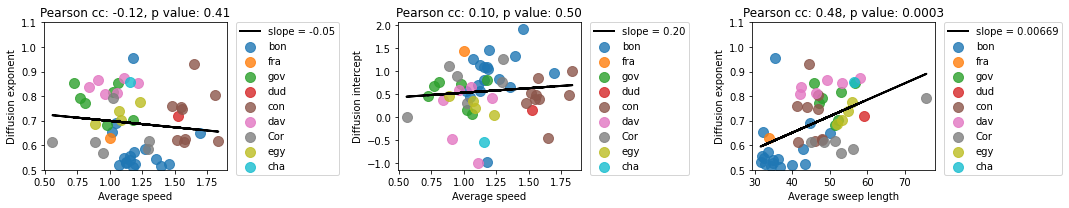

In [31]:
#plot ave_speed against replay_exponent for each animal, each with different color in subplot 1
#plot sweep_len against replay_exponent for each animal, each with different color in subplot 2
#using all_ave_speed_peranimal, all_sweep_len_peranimal, all_exponent_peranimal here

#select colors equals to number of animals from a colormap
#put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap('tab10', len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)

plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_peranimal[name]), np.array(all_exponent_peranimal[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
all_exp_np = np.concatenate(list(all_exponent_peranimal.values()))
all_speed_np = np.concatenate(list(all_ave_speed_peranimal.values()))
#add linear fit line to all_exp_np vs all_speed_np
slope, intercept = np.polyfit(all_speed_np, all_exp_np, 1)
plt.plot(all_speed_np, all_speed_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(all_speed_np, all_exp_np)
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
plt.xlabel('Average speed')
plt.ylabel('Diffusion exponent')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

#intercept
plt.subplot(1,3,2)
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_peranimal[name]), np.array(all_intercept_peranimal[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
    
all_intercept_np = np.concatenate(list(all_intercept_peranimal.values()))
all_speed_np = np.concatenate(list(all_ave_speed_peranimal.values()))
#add linear fit line to all_exp_np vs all_speed_np
slope, intercept = np.polyfit(all_speed_np, all_intercept_np, 1)
plt.plot(all_speed_np, all_speed_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(all_speed_np, all_intercept_np)
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
plt.xlabel('Average speed')
plt.ylabel('Diffusion intercept')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(1,3,3)
for name in animal_names:
    plt.scatter(np.array(all_sweep_len_peranimal[name]), np.array(all_exponent_peranimal[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
all_exp_np = np.concatenate(list(all_exponent_peranimal.values()))
all_sweep_len_np = np.concatenate(list(all_sweep_len_peranimal.values()))
#add linear fit line to all_exp_np vs all_speed_np
slope, intercept = np.polyfit(all_sweep_len_np, all_exp_np, 1)
plt.plot(all_sweep_len_np, all_sweep_len_np*slope+intercept, 'k-', label='slope = %.5f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(all_sweep_len_np, all_exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

plt.tight_layout()

# store animal_names, all_sweep_len_perday_concat, all_exponent_perday_concat together in one pkl file 
# using pickle for producing paper figure in another script
import pickle
with open('../../Processed-Data/sweep_sleepreplay_correlation_realdata_persession.pkl', 'wb') as f:
    pickle.dump([animal_names, all_ave_speed_peranimal, all_sweep_len_peranimal, all_exponent_peranimal, all_intercept_peranimal], f)


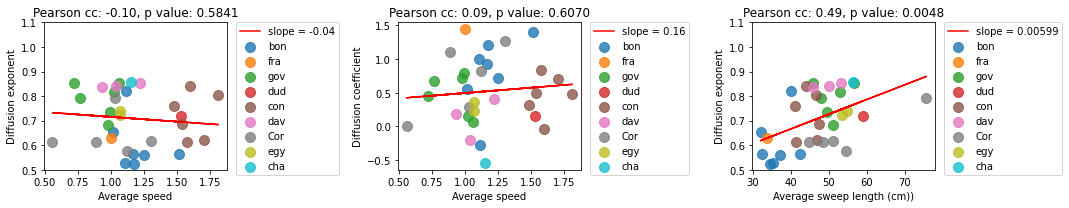

In [6]:
#plot ave_speed against replay_exponent for each animal, each with different color in subplot 1
#plot sweep_len against replay_exponent for each animal, each with different color in subplot 2
#using all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday here

#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_peranimal = {}

#first avearge all the values under each key in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday
all_ave_speed_perday_ave = {}
all_sweep_len_perday_ave = {}
all_exponent_perday_ave = {}
all_intercept_perday_ave = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_ave[key] = np.mean(all_ave_speed_perday[key])
    all_sweep_len_perday_ave[key] = np.mean(all_sweep_len_perday[key])
    all_exponent_perday_ave[key] = np.mean(all_exponent_perday[key])
    all_intercept_perday_ave[key] = np.mean(all_intercept_perday[key])
    
#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_perday_concat = {}
all_sweep_len_perday_concat = {}
all_exponent_perday_concat = {}
all_intercept_perday_concat = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_concat.setdefault(key[0], []).append(all_ave_speed_perday_ave[key])
    all_sweep_len_perday_concat.setdefault(key[0], []).append(all_sweep_len_perday_ave[key])
    all_exponent_perday_concat.setdefault(key[0], []).append(all_exponent_perday_ave[key])
    all_intercept_perday_concat.setdefault(key[0], []).append(all_intercept_perday_ave[key])
   
#select colors equals to number of animals from a colormap
#put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap('tab10', len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)
 
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
#plot all_exponent_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_speed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, exp_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'r-', label='slope = %.2f'%slope)

#pearson test
corr, p = pearsonr(speed_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average speed')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

#intercept
plt.subplot(1,3,2)
#plot all_intercept_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_intercept_perday_concat to numpy array
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_speed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, intercept_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'r-', label='slope = %.2f'%slope)

#pearson test
corr, p = pearsonr(speed_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average speed')
plt.ylabel('Diffusion coefficient')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(1,3,3)
#plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_len_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])   
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
plt.plot(sweep_len_np, sweep_len_np*slope+intercept, 'r-', label='slope = %.5f'%slope)
#pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep length (cm))')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

plt.tight_layout()
plt.show()

# store animal_names, all_sweep_len_perday_concat, all_exponent_perday_concat together in one pkl file 
# using pickle for producing paper figure in another script
import pickle
with open('../../Processed-Data/sweep_sleepreplay_correlation_realdata.pkl', 'wb') as f:
    pickle.dump([animal_names, all_ave_speed_perday_concat, all_sweep_len_perday_concat, all_exponent_perday_concat, all_intercept_perday_concat], f)


In [4]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap

#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_peranimal = {}

#first avearge all the values under each key in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday
all_ave_speed_perday_ave = {}
all_sweep_len_perday_ave = {}
all_exponent_perday_ave = {}
all_intercept_perday_ave = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_ave[key] = np.mean(all_ave_speed_perday[key])
    all_sweep_len_perday_ave[key] = np.mean(all_sweep_len_perday[key])
    all_exponent_perday_ave[key] = np.mean(all_exponent_perday[key])
    all_intercept_perday_ave[key] = np.mean(all_intercept_perday[key])
    
#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_perday_concat = {}
all_sweep_len_perday_concat = {}
all_exponent_perday_concat = {}
all_intercept_perday_concat = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_concat.setdefault(key[0], []).append(all_ave_speed_perday_ave[key])
    all_sweep_len_perday_concat.setdefault(key[0], []).append(all_sweep_len_perday_ave[key])
    all_exponent_perday_concat.setdefault(key[0], []).append(all_exponent_perday_ave[key])
    all_intercept_perday_concat.setdefault(key[0], []).append(all_intercept_perday_ave[key])
   
#select colors equals to number of animals from a colormap
#put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap('tab10', len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)
 
plt.figure(figsize=(1.8,2.2), dpi=300)
plt.subplot(1,1,1)
#top and right spine off
ax = plt.gca()
labelsize=8
ticksize=6

#plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_len_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                s=15, alpha=0.8, color=color_dict[name])   
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
corr, p = pearsonr(exp_np, sweep_len_np)
ax.plot(sweep_len_np, sweep_len_np * slope + intercept, "k-", label="r = %.2f, p = %.3f" % (corr, p), linewidth=1,)
#pearson test
ax.set_xlabel('Average sweep \n length (cm)')
ax.set_ylabel('Diffusion expo.')
#put the legend outside the plot on the right side
ax.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.2))
ax.set_yticks([0.6, 0.8, 1.0])
ax.set_ylim([0.5, 1.0])

#xtick
ax.set_xticks([40,60])
ax.set_xlim([30,65])

colors = plt.cm.get_cmap("tab10", len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)

#add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=labelsize)
# remove the box of the colorbar
cbar.outline.set_visible(False)
#cbar tick size
cbar.ax.tick_params(labelsize=6)

ax.tick_params(labelsize=ticksize)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# axis line width 1.0
ax.spines["bottom"].set_linewidth(1.0)
ax.spines["left"].set_linewidth(1.0)
# remove the tick bars on the left and bottom
ax.tick_params(axis="both", which="both", length=0)

plt.tight_layout()


plt.savefig('/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/FigSI_ThetaSleepreplayCorrelation.pdf', bbox_inches='tight')

NameError: name 'all_ave_speed_perday' is not defined

### load data without calculating sweep length...

awake 0.49926010046252556 0.00014148149770708447 0.24926064791385105 53
sleep 0.4857932692978646 0.0048220529895440685 0.23599510049510752 32


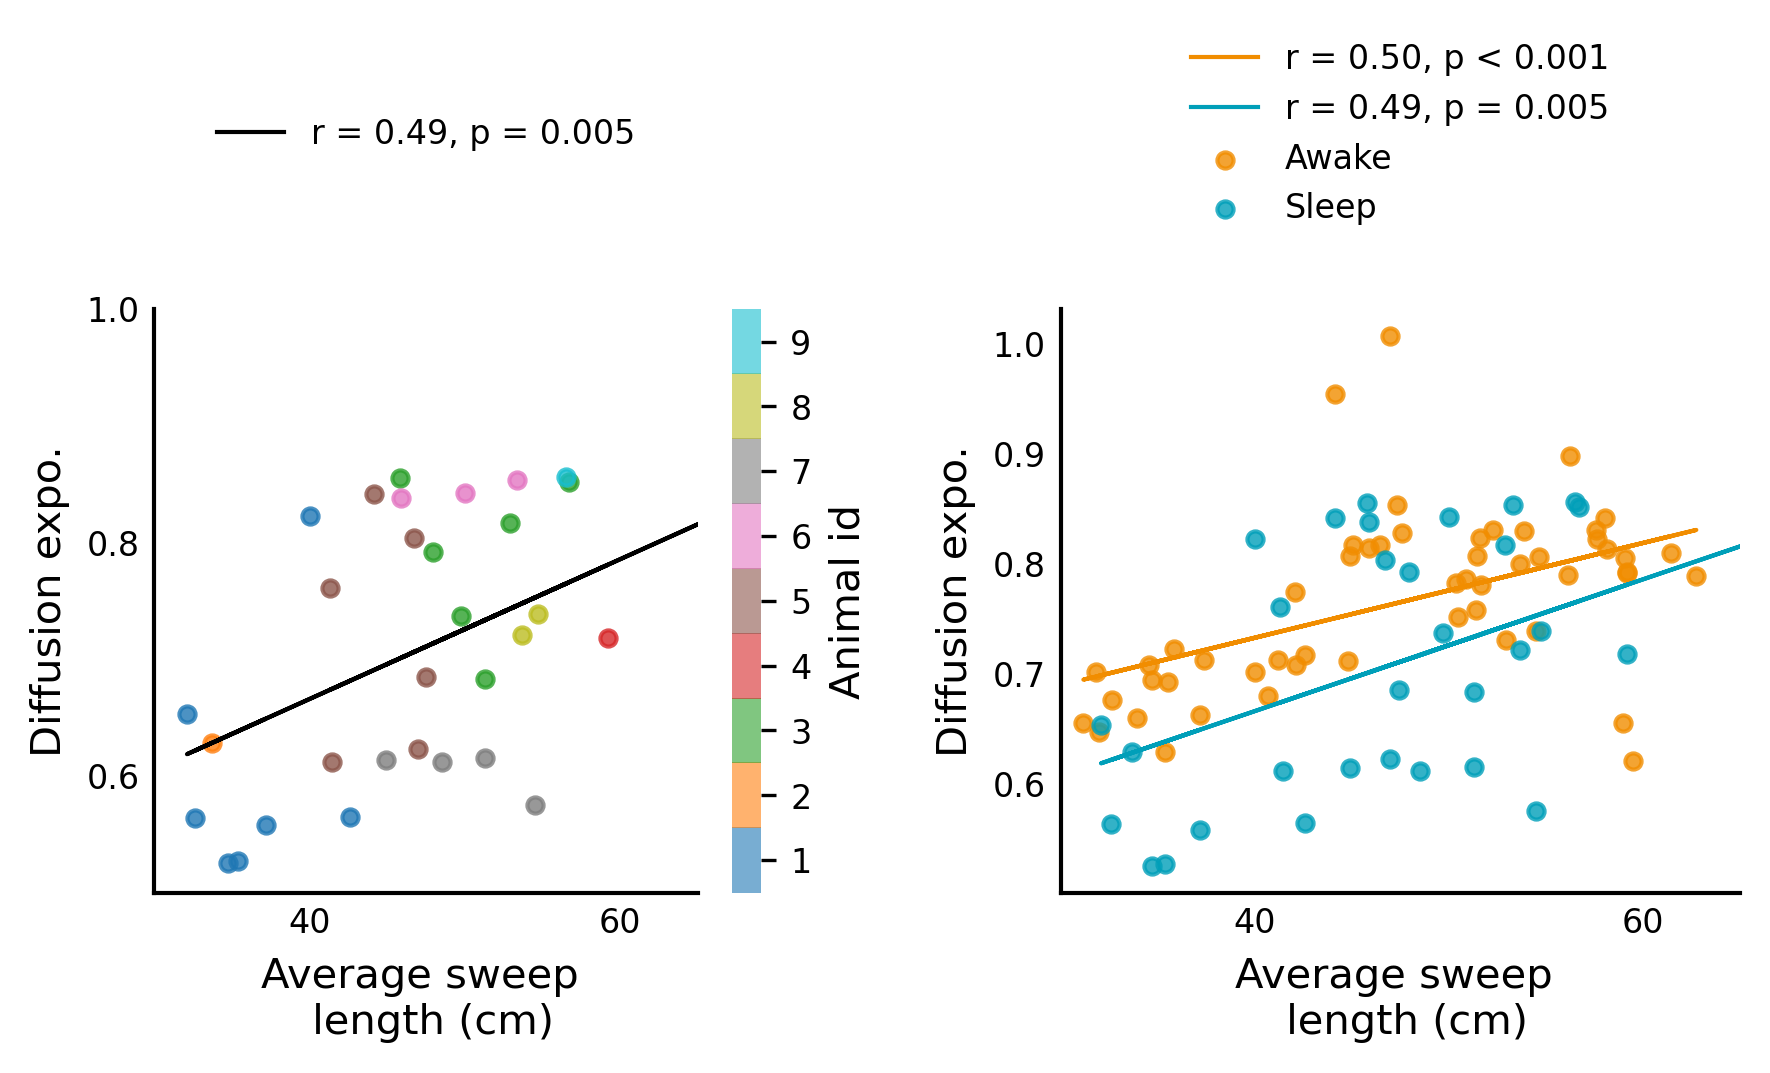

In [5]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap

import pickle   
with open('../../Processed-Data/sweep_sleepreplay_correlation_realdata.pkl', 'rb') as f:
    [animal_names, 
     _, 
     all_sweep_len_perday_concat, 
     all_exponent_perday_concat, 
     _] = pickle.load(f)

#select colors equals to number of animals from a colormap
#put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap('tab10', len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)
 
fig = plt.figure(figsize=(6,4), dpi=300)
gs = fig.add_gridspec(1, 2)
#top and right spine off
ax = fig.add_subplot(gs[0, 0])
labelsize=10
ticksize=8

#plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_len_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                s=15, alpha=0.8, color=color_dict[name])   
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
corr, p = pearsonr(exp_np, sweep_len_np)
ax.plot(sweep_len_np, sweep_len_np * slope + intercept, "k-", label="r = %.2f, p = %.3f" % (corr, p), linewidth=1,)
#pearson test
ax.set_xlabel('Average sweep \n length (cm)', fontsize=labelsize)
ax.set_ylabel('Diffusion expo.', fontsize=labelsize)
#put the legend outside the plot on the right side
ax.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.3))
ax.set_yticks([0.6, 0.8, 1.0])
ax.set_ylim([0.5, 1.0])

#xtick
ax.set_xticks([40,60])
ax.set_xlim([30,65])

colors = plt.cm.get_cmap("tab10", len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)

#add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=labelsize)
# remove the box of the colorbar
cbar.outline.set_visible(False)
#cbar tick size
cbar.ax.tick_params(labelsize=8)

ax1 = fig.add_subplot(gs[0, 1])
from sklearn.metrics import r2_score
#put awake replay and sleep replay together
with open("../../Processed-Data/sweep_replay_correlation_realdata.pkl", "rb") as f:
    (
        animal_names,
        awake_sweep_len_perday_concat,
        awake_sweep_amp_perday_concat,
        awake_sweep_ahead_perday_concat,
        awake_sweep_behind_perday_concat,
        awake_exponent_perday_concat,
        awake_ave_activespeed_perday_concat,
    ) = pickle.load(f)

exp_np = np.concatenate(list(awake_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(awake_sweep_amp_perday_concat.values()))
#plot awake_exponent_perday_concat against awake_sweep_amp_perday_concat
ax1.scatter(sweep_len_np, exp_np, s=15, alpha=0.8, color='#F18D00', label='Awake')
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(awake_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(awake_sweep_amp_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
corr, p = pearsonr(exp_np, sweep_len_np)
#calculate R square of the linear fit between sweep_len_np and exp_np
exp_np_true = exp_np
exp_np_pred = sweep_len_np * slope + intercept
r2 = r2_score(exp_np_true, exp_np_pred)
print('awake', corr, p, r2, len(exp_np))
if p<0.001:
    ax1.plot(sweep_len_np, sweep_len_np * slope + intercept, "#F18D00", label="r = %.2f, p < 0.001" % (corr), linewidth=1,)
else:
    ax1.plot(sweep_len_np, sweep_len_np * slope + intercept, "#F18D00", label="r = %.2f, p = %.3f" % (corr, p), linewidth=1,)


#plot sleep_exponent_perday_concat against sleep_sweep_len_perday_concat
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
plt.scatter(sweep_len_np, exp_np, s=15, alpha=0.8, color='#009FB9', label='Sleep')

slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
corr, p = pearsonr(exp_np, sweep_len_np)
#calculate R square of the linear fit between sweep_len_np and exp_np
exp_np_true = exp_np
exp_np_pred = sweep_len_np * slope + intercept
r2 = r2_score(exp_np_true, exp_np_pred)
print('sleep', corr, p, r2, len(exp_np))
if p<0.001:
    ax1.plot(sweep_len_np, sweep_len_np * slope + intercept, "#009FB9", label="r = %.2f, p < 0.001" % (corr), linewidth=1,)
else:
    ax1.plot(sweep_len_np, sweep_len_np * slope + intercept, "#009FB9", label="r = %.2f, p = %.3f" % (corr, p), linewidth=1,)

#pearson test
ax1.set_xlabel('Average sweep \n length (cm)', fontsize=labelsize)
ax1.set_ylabel('Diffusion expo.', fontsize=labelsize)

ax1.set_xticks([40,60])
ax1.set_xlim([30,65])

#legend
ax1.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.3))
    
for ax in [ax, ax1]:
    ax.tick_params(labelsize=ticksize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # axis line width 1.0
    ax.spines["bottom"].set_linewidth(1.0)
    ax.spines["left"].set_linewidth(1.0)
    # remove the tick bars on the left and bottom
    ax.tick_params(axis="both", which="both", length=0)   
    
plt.tight_layout()

plt.savefig('/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/Fig_SI_ThetaSleepreplayCorrelation.pdf', bbox_inches='tight')

### put awake replay and sleep replay in the same plot

awake 0.49926010046252556 0.00014148149770708447 0.24926064791385105 53
sleep 0.4857932692978646 0.0048220529895440685 0.23599510049510752 32


(30.0, 65.0)

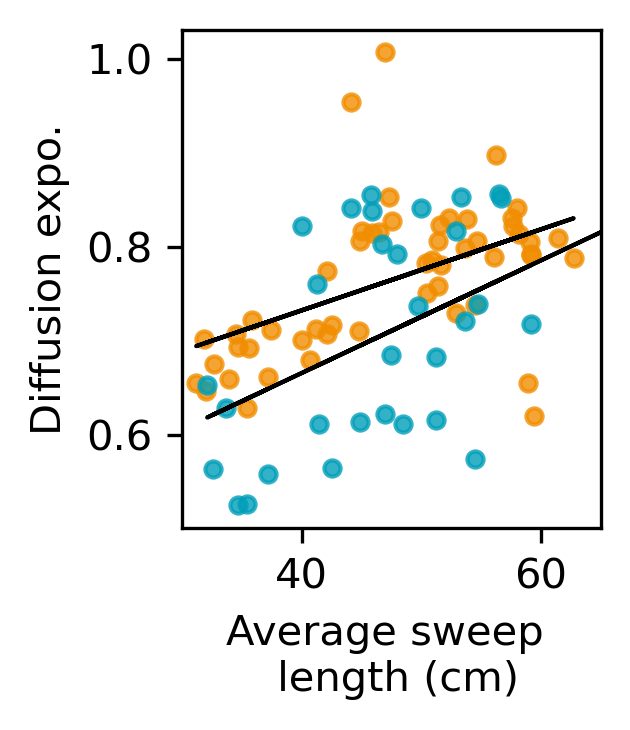

In [9]:
from sklearn.metrics import r2_score

#put awake replay and sleep replay together
with open("../../Processed-Data/sweep_replay_correlation_realdata.pkl", "rb") as f:
    (
        animal_names,
        awake_sweep_len_perday_concat,
        awake_sweep_amp_perday_concat,
        awake_sweep_ahead_perday_concat,
        awake_sweep_behind_perday_concat,
        awake_exponent_perday_concat,
        awake_ave_activespeed_perday_concat,
    ) = pickle.load(f)
    
with open('../../Processed-Data/sweep_sleepreplay_correlation_realdata.pkl', 'rb') as f:
    [animal_names, 
     sleep_ave_speed_perday_concat, 
     sleep_sweep_len_perday_concat, 
     sleep_exponent_perday_concat, 
     sleep_intercept_perday_concat] = pickle.load(f)
    
#plot awake_sweep_amp_perday_concat vs awake_exponent_perday_concat as blue dots
#plot sleep_sweep_len_perday_concat vs sleep_exponent_perday_concat as red dots 
#in one figure

#select colors equals to number of animals from a colormap
#put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap('tab10', len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)
 
plt.figure(figsize=(1.8,2.2), dpi=300)
plt.subplot(1,1,1)
#top and right spine off
ax = plt.gca()
labelsize=8
ticksize=6

exp_np = np.concatenate(list(awake_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(awake_sweep_amp_perday_concat.values()))
#plot awake_exponent_perday_concat against awake_sweep_amp_perday_concat
plt.scatter(sweep_len_np, 
            exp_np,
            s=15, alpha=0.8, color='#F18D00')   
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(awake_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(awake_sweep_amp_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
corr, p = pearsonr(exp_np, sweep_len_np)
#calculate R square of the linear fit between sweep_len_np and exp_np
exp_np_true = exp_np
exp_np_pred = sweep_len_np * slope + intercept
r2 = r2_score(exp_np_true, exp_np_pred)
print('awake', corr, p, r2, len(exp_np))
ax.plot(sweep_len_np, sweep_len_np * slope + intercept, "k-", label="r = %.2f, p = %.3f" % (corr, p), linewidth=1,)


#plot sleep_exponent_perday_concat against sleep_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(sleep_sweep_len_perday_concat[name]), 
                np.array(sleep_exponent_perday_concat[name]), 
                s=15, alpha=0.8, color='#009FB9')
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(sleep_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(sleep_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
corr, p = pearsonr(exp_np, sweep_len_np)
#calculate R square of the linear fit between sweep_len_np and exp_np
exp_np_true = exp_np
exp_np_pred = sweep_len_np * slope + intercept
r2 = r2_score(exp_np_true, exp_np_pred)
print('sleep', corr, p, r2, len(exp_np))
ax.plot(sweep_len_np, sweep_len_np * slope + intercept, "k-", label="r = %.2f, p = %.3f" % (corr, p), linewidth=1,)
#pearson test
ax.set_xlabel('Average sweep \n length (cm)')
ax.set_ylabel('Diffusion expo.')

ax.set_xticks([40,60])
ax.set_xlim([30,65])
    

### put awake and sleeo replay persession in the same plot

awake 0.36059786470478267 1.3951519229354922e-05
sleep 0.48108895760429266 0.0003058559717464609


(30.0, 65.0)

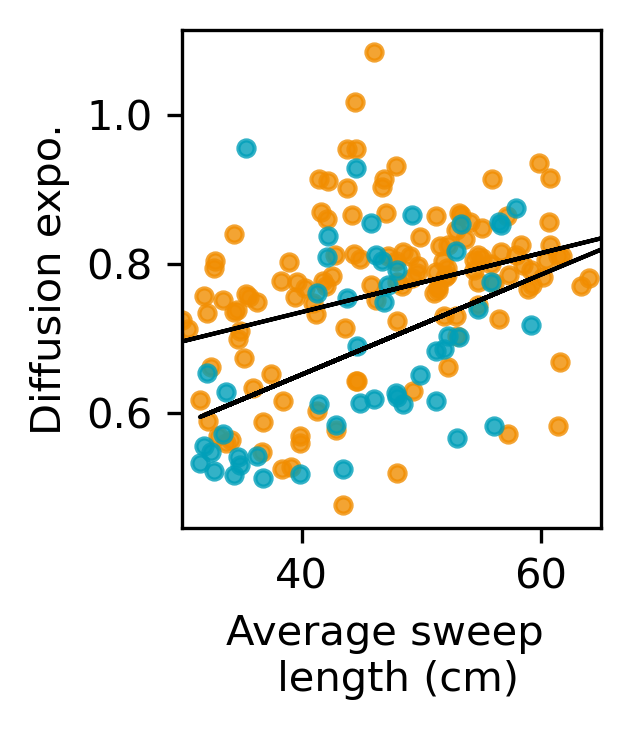

In [35]:
#put awake replay and sleep replay together
with open("../../Processed-Data/sweep_replay_correlation_realdata_persession.pkl", "rb") as f:
    (
        animal_names,
        awake_sweep_len_peranimal,
        awake_sweep_amp_peranimal,
        awake_sweep_ahead_peranimal,
        awake_sweep_behind_peranimal,
        awake_exponent_peranimal,
        awake_ave_activespeed_peranimal,
    ) = pickle.load(f)
    
with open('../../Processed-Data/sweep_sleepreplay_correlation_realdata_persession.pkl', 'rb') as f:
    [animal_names, 
     sleep_ave_speed_peranimal, 
     sleep_sweep_len_peranimal, 
     sleep_exponent_peranimal, 
     sleep_intercept_peranimal] = pickle.load(f)
    
#plot awake_sweep_amp_perday_concat vs awake_exponent_perday_concat as blue dots
#plot sleep_sweep_len_perday_concat vs sleep_exponent_perday_concat as red dots 
#in one figure

#select colors equals to number of animals from a colormap
#put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap('tab10', len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)
 
plt.figure(figsize=(1.8,2.2), dpi=300)
plt.subplot(1,1,1)
#top and right spine off
ax = plt.gca()
labelsize=8
ticksize=6

exp_np = np.concatenate(list(awake_exponent_peranimal.values()))
sweep_len_np = np.concatenate(list(awake_sweep_amp_peranimal.values()))
#plot awake_exponent_perday_concat against awake_sweep_amp_perday_concat
plt.scatter(sweep_len_np, 
            exp_np,
            s=15, alpha=0.8, color='#F18D00')   
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(awake_exponent_peranimal.values()))
sweep_len_np = np.concatenate(list(awake_sweep_amp_peranimal.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
corr, p = pearsonr(exp_np, sweep_len_np)
print('awake', corr, p)
ax.plot(sweep_len_np, sweep_len_np * slope + intercept, "k-", label="r = %.2f, p = %.3f" % (corr, p), linewidth=1,)


#plot sleep_exponent_perday_concat against sleep_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(sleep_sweep_len_peranimal[name]), 
                np.array(sleep_exponent_peranimal[name]), 
                s=15, alpha=0.8, color='#009FB9')
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(sleep_exponent_peranimal.values()))
sweep_len_np = np.concatenate(list(sleep_sweep_len_peranimal.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
corr, p = pearsonr(exp_np, sweep_len_np)
print('sleep', corr, p)
ax.plot(sweep_len_np, sweep_len_np * slope + intercept, "k-", label="r = %.2f, p = %.3f" % (corr, p), linewidth=1,)
#pearson test
ax.set_xlabel('Average sweep \n length (cm)')
ax.set_ylabel('Diffusion expo.')

ax.set_xticks([40,60])
ax.set_xlim([30,65])
    